In [81]:
import torch
from torch import nn
from functools import partial
import einops
import matplotlib.pyplot as plt

from typing import Tuple

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(1e2)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

pos_embedding: torch.Size([1024, 128])


ValueError: label must be scalar or have the same length as the input data, but found 1024 for 128 datasets.

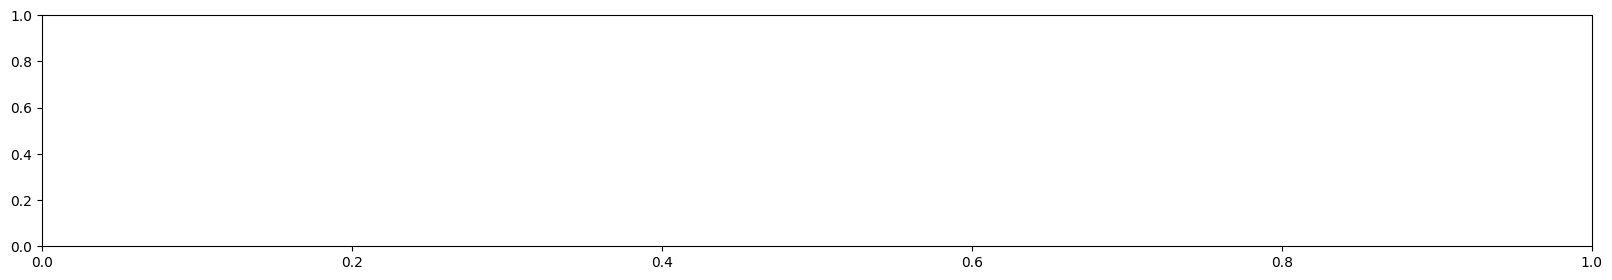

In [90]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def embed(self, p, dim):
        half_dim = dim // 2
        embeddings = torch.log(torch.tensor(self.dim//16)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=p.device) * -embeddings)
        embeddings = p[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

    def forward(self, p_x, p_y):
        half_dim = self.dim // 2
        embeddings_x = self.embed(p_x, half_dim)
        embeddings_y = self.embed(p_y, half_dim)
        embeddings = torch.cat((embeddings_x, embeddings_y), dim=-1)
        return embeddings



img_size = 1024
patch_size = 32
patches_in_row = img_size//patch_size
n_patches = (patches_in_row) ** 2

p_x = torch.arange(patches_in_row)
p_y = torch.arange(patches_in_row)
poses = torch.cartesian_prod(p_x, p_y)

sembed = SinusoidalPositionEmbeddings(dim=128)
pos_embedding = sembed(poses[:,0], poses[:,1])
print(f"pos_embedding: {pos_embedding.shape}")

labels = []
for i, j in poses:
    labels.append(f"({i}, {j})")

plt.figure(figsize=(20, 3))
plt.plot(pos_embedding, label=labels)
# plt.legend()

# plt.imshow(res)
None

In [100]:
class PatchEmbedding(nn.Module):
    def __init__(
        self, 
        patch_size: Tuple[int, int],
        latent_size: int,
        hw_size: Tuple[int, int],
        n_channel: int,
        batch_size: int,
        device: torch.device.type,
        *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        
        self.patch_size = patch_size
        
        self.linear_projection = nn.Linear(patch_size[0]*patch_size[1]*n_channel, latent_size)
        self.segment_token = nn.Parameter(torch.randn(batch_size, 1, latent_size), requires_grad=True).to(device)
        
        p_r = torch.arange(1, hw_size[0]//patch_size[0]+1)
        p_c = torch.arange(1, hw_size[1]//patch_size[1]+1)
        poses = torch.cartesian_prod(p_r, p_c)+1
        poses = torch.concat([torch.zeros((1, 2)), poses], dim=0)
        sembed = SinusoidalPositionEmbeddings(dim=latent_size)
        self.pos_embedding = sembed(poses[:,0], poses[:,1]).to(device)
        
    def forward(self, x):
        patches = einops.rearrange(
            x, 
            "b c (h h1) (w w1) -> b (h w) (h1 w1 c)", 
            h1=self.patch_size[0], w1=self.patch_size[1]
        )
        projected_patches = self.linear_projection(patches)
        x = torch.concat([self.segment_token, projected_patches], dim=1)
        pos_embedding = einops.repeat(self.pos_embedding, "p d -> b p d", b=x.shape[0])
        
        print(x.shape, pos_embedding.shape)
        x += pos_embedding
        return x

In [101]:
x = torch.randn(size=(8, 3, 1024, 1024))

embedder = PatchEmbedding(
    patch_size=(32, 32),
    latent_size = 64,
    hw_size = (1024, 1024),
    n_channel = 3,
    batch_size = 8,
    device = "cpu"
)

y = embedder(x)

print(f"input shape: {x.shape}, output shape: {y.shape}")

torch.Size([8, 1025, 64]) torch.Size([8, 1025, 64])
input shape: torch.Size([8, 3, 1024, 1024]), output shape: torch.Size([8, 1025, 64])


In [99]:
torch.zeros((1, 2))

tensor([[0., 0.]])